# Housing - exploratory data analysis (EDA)

NYC housing dataset b/w in 2012-13, seperated by boroughs

- [x] get an intuitive understanding, 
- [x] clear data
- [x] adjust columns data types
- [x] adjust columns
- [x] enrich
- [x] missing values
- [x] outliers
- [x] visualize for yourself
- [ ] visualize for client
- [ ] make cross comparisons
- [x] then **create an OUTPUT file for other models**

##### Notes
- **raw_data** is readed file w/ proper types and formats
- **data_prepared**, dataframe after missing values (sale_price) and **obvious** rows/columns eliminated
- **data_cleaned**,  dataframe after **outliers** eliminated
- **data_enriched**, starts w/ data, + null row deletions, enrichments (_map, _log ..)  etc...

### possible deletion columns/rows

   - columns
       - borough, building_class_category .. (extracted into diff. columns)
       - block, lot (nonsense)
       - easement (%100 empty), 
       - apartment_number (%74 empty)
   - rows
       - **30% of sale_price is 0 (28K+)**
       - building_class_name is null, is **(1500)**
       - tax_class_at_present is empty, is **(270)**     
   - outliers  
       - (data_cleaned.gross_square_feet > 0) & (data_cleaned.gross_square_feet <= 20K)
       - (data_cleaned.sale_price < 2M)  


### categorical features

  - building_class_at_present: may be mapped into 3 groups to use later ?
      - if containf FAMILY, Map as FAMILY in building_class_map
  - building_class_at_present vs building_class_at_sale change has any meaning?
  - tax_class_at_present vs tax_class_at_sale has any meaning? (1, 2 and 4 is dominating values)
  - 10019 zipcode is %7 of houses, and 70K houses are located in of 100 zipcodes
  - 4000+ diff. apartment_number in 85K rows.
  - top 50 neighborhood covers 50K+ houses
  
### numerical features

  - **50% of estates has 0 land_square_feet and gross_square_feet.**
  - **how can residential_units and commercial_units be used as numeric columns in a meaningful way?**
      - residential_units (165 types), %50 is 0 and 1 (40K+ rows) and 30K+ NaN. 
      - commercial_units (23 types), 0 has 20K+, NaN is 60K+
      - total_units (171 types), 1 (25K+, 0 (16K+), 2 (8K+) and **NaN is 30K**
         - total = residental + commercial ?
         - if there are dif, can we set to commercial or we should delete  or we may use to create a dummy category ?
         - if total = 0 or null **(18K rows)** , what we should do?

- [ ] **can we predict total_units, then set null values, then make them numeric**
- [ ] **can we predict year_built, then set 0 values,


In [407]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import glob

sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)


In [416]:
# read all datasets w/ dates
filenames = glob.glob(os.path.join('dataset/housing/', 'r*.csv'))

#
li = []

for filename in filenames:
    df = pd.read_csv(filename, \
                dtype={'YEAR BUILT': object, 'BLOCK': object, 'LOT': object, 'ZIP CODE': object, 
                       'COMMERCIAL UNITS': object,
                       'BOROUGH': object, 'NEIGHBORHOOD': object, 'BUILDING CLASS CATEGORY': object,
                       'TAX CLASS AT PRESENT': object,  'EASE-MENT': object,
                       'BUILDING CLASS AT PRESENT': object, 'ADDRESS': object, 
                       'APART\nMENT\nNUMBER': object,
                       'RESIDENTIAL UNITS': object, 'COMMERCIAL UNITS': object, 'TOTAL UNITS': object,
                       'LAND SQUARE FEET': object, 'GROSS SQUARE FEET': object,
                       'TAX CLASS AT TIME OF SALE': object, 'BUILDING CLASS AT TIME OF SALE': object,
                       'SALE\nPRICE': object}, \
                parse_dates=['SALE DATE'], \
                infer_datetime_format=True)
    li.append(df)


raw_data = pd.concat(li, axis=0, ignore_index=True)

# change column names
raw_data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'year_built',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

raw_data.head(2)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09
1,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1105,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$218,010",2013-07-12


#### Do data format corrections

In [417]:
# map and extract some of them, delete white-spaces, delete ',' from number columns
raw_data['borough_name'] = raw_data['borough'].map({1:'Manhattan', 3:'Brooklyn', 
                                                    2:'Bronx', 4:'Queens', 
                                                    5:'Staten Island'})   

raw_data['neighborhood'] = raw_data['neighborhood'].str.split(r'(\s+)$', expand=True)[0]

raw_data['residential_units'] = raw_data['residential_units'].str.replace(r',', '')
raw_data['commercial_units'] = raw_data['commercial_units'].str.replace(r',', '')
raw_data['total_units'] = raw_data['total_units'].str.replace(r',', '')
    
#  white-spaces at the beginning, white-spaces at the end cleared
#  b/w words, white-space remains 
raw_data['address_'] = raw_data['address'].str.split(r'(^\s+)|(\s+)$', expand=True)[3]

# whitespace at end
# then, extract 01 and CONDOS - xyz part
# 01 CONDOS - xyz klm    
raw_data['building_class'] = raw_data['building_class_category'].str.split(r'(\s+)$', expand=True)[0] \
                                                                .str.split(r'(^\S+)(\s+)', expand=True)[1]

raw_data['building_class_name'] = raw_data['building_class_category'].str.split(r'(\s+)$', expand=True)[0] \
                                                                     .str.split(r'(^\S+)(\s+)', expand=True)[3]


for col in ('land_square_feet', 'gross_square_feet'):
    raw_data[col] = raw_data[col].str.replace(r',', '').astype(int)
    

raw_data['sale_price'] = raw_data['sale_price'].str.replace(r',|\$', '').astype(float)

# change column names' order
raw_data = raw_data[['borough', 'borough_name' , 'neighborhood',
                     'building_class_category', 'building_class', 'building_class_name',
                     'tax_class_at_present', 'tax_class_at_sale', 
                     'block', 'lot', 'easement','building_class_at_present', 'building_class_at_sale', 
                     'address', 'address_', 'apartment_number','zipcode',
                     'residential_units', 'commercial_units', 'total_units',
                     'land_square_feet', 'gross_square_feet', 
                     'year_built','sale_date', 'sale_price']]

raw_data.head(3)

,borough,borough_name,neighborhood,building_class_category,building_class,building_class_name,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,address_,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
0,3,NaN,,15 CONDOS - 2-10 UNIT RESIDENTIAL,15,CONDOS - 2-10 UNIT RESIDENTIAL,,2,814,1103,,,R1,342 53RD STREET,342 53RD STREET,,11220,0,0,0,0,0,0,2013-07-09,403572.0
1,3,NaN,,15 CONDOS - 2-10 UNIT RESIDENTIAL,15,CONDOS - 2-10 UNIT RESIDENTIAL,,2,814,1105,,,R1,342 53RD STREET,342 53RD STREET,,11220,0,0,0,0,0,0,2013-07-12,218010.0
2,3,NaN,,15 CONDOS - 2-10 UNIT RESIDENTIAL,15,CONDOS - 2-10 UNIT RESIDENTIAL,,2,1967,1401,,,R1,290 GREENE AVE,290 GREENE AVE,,11238,0,0,0,0,0,0,2013-04-25,952311.0


In [415]:
raw_data.dtypes

borough                              object
borough_name                         object
neighborhood                         object
building_class_category              object
building_class                       object
building_class_name                  object
tax_class_at_present                 object
tax_class_at_sale                    object
block                                object
lot                                  object
easement                             object
building_class_at_present            object
building_class_at_sale               object
address                              object
address_                             object
apartment_number                     object
zipcode                              object
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                      int64
gross_square_feet                     int64
year_built                      

In [418]:
raw_data.describe(include='all')

,borough,borough_name,neighborhood,building_class_category,building_class,building_class_name,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,address_,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
count,85975,0.0,85975,85975,81771,81771,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,8.597500e+04,8.597500e+04,85975,85975,8.597500e+04
unique,5,0.0,257,40,39,39,11,5,11043,2496,2,170,170,63419,63419,4492,185,178,63,187,NaN,NaN,160,386,NaN
top,1,NaN,MIDTOWN WEST,01 ONE FAMILY HOMES,01,ONE FAMILY HOMES,2,2,1027,1,,D4,D4,870 7 AVENUE,870 7 AVENUE,,10019,1,0,1,NaN,NaN,0,2012-09-27 00:00:00,NaN
freq,27395,NaN,6264,14846,14846,14846,32899,38662,2735,4015,85973,13461,13461,2087,2087,63830,6193,31393,77358,38672,NaN,NaN,11782,988,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.085275e+03,5.049742e+03,NaN,NaN,8.850979e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501497e+04,2.836546e+04,NaN,NaN,9.424213e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00


## Analysis in Detail - Missing,  Format Problems etc..

- all results below section applied to the **raw_data**
- **data_prepared** is the outcome data frame

In [273]:
kkk = pd.DataFrame(raw_data['building_class_category'])


# (^\s)|(\s+)$
# r'(\s+)$' and r'(^\S+)(\s+)

kkk['building_class_category_'] = kkk['building_class_category'].str.split(r'(\s+)$', expand=True)[0].str.split(r'(^\S+)(\s+)')
# kkk['_len'] = kkk['building_class_category'].str.len()
# kkk['__len'] = kkk['building_class_category'].str.len()
# kkk['__diff'] = kkk._len - kkk.__len


kkk.head(10)
# kkk[kkk.__diff > 0 ]
# kkk[kkk.total_units == '']

,building_class_category,building_class_category_
0,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
1,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
2,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
3,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
4,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
5,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
6,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
7,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
8,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"
9,13 CONDOS - ELEVATOR APARTMENTS,"[, 13, , CONDOS - ELEVATOR APARTMENTS]"


In [274]:
kkk = pd.DataFrame(raw_data['total_units'])


# (^\s)|(\s+)$

kkk['total_units_'] = kkk['total_units'].str.split(r'(\s+)$|,', expand=True)[0]
kkk['total_units_len'] = kkk['total_units'].str.len()
kkk['total_units__len'] = kkk['total_units'].str.len()
kkk['total_units__diff'] = kkk.total_units_len - kkk.total_units__len


kkk[kkk.total_units__diff > 0 ]
# kkk[kkk.total_units == '']

,total_units,total_units_,total_units_len,total_units__len,total_units__diff


In [275]:
len(kkk[kkk.total_units.isna()])

29729

In [276]:
kkk.groupby('total_units').size().sort_values(ascending=False).head(10)#.plot()

total_units
1     25991
0     16133
2      8178
3      2289
4       612
6       450
5       323
10      192
8       182
7       166
dtype: int64

In [277]:
kkk = pd.DataFrame(raw_data['commercial_units'])


# (^\s)|(\s+)$

kkk['commercial_units_'] = kkk['commercial_units'].str.split(r'(\s+)$|,', expand=True)[0]
kkk['commercial_units_len'] = kkk['commercial_units'].str.len()
kkk['commercial_units__len'] = kkk['commercial_units'].str.len()
kkk['commercial_units__diff'] = kkk.commercial_units_len - kkk.commercial_units__len


len(kkk[kkk.commercial_units.isna()])
# kkk[kkk.commercial_units.i]

62392

In [278]:
kkk.groupby('commercial_units').size().sort_values(ascending=False).head(10)#.plot()

commercial_units
0     21998
1      1182
2       181
3        80
5        36
4        34
7        14
6        14
9         8
11        7
dtype: int64

In [284]:
kkk = pd.DataFrame(raw_data['residential_units'])


# (^\s)|(\s+)$

kkk['residential_units_'] = kkk['residential_units'].str.split(r'(\s+)$|,', expand=True)[0]
kkk['residential_units_len'] = kkk['residential_units'].str.len()
kkk['residential_units__len'] = kkk['residential_units'].str.len()
kkk['residential_units__diff'] = kkk.residential_units_len - kkk.residential_units__len


kkk[kkk.residential_units__diff > 0]

,residential_units,residential_units_,residential_units_len,residential_units__len,residential_units__diff


In [285]:
len(kkk[kkk.residential_units.isna()])

29729

In [292]:
# we can set empty residential_units w/ means by building_class_name,
# or we can cluster then, predict more meaningful values?

xyz = raw_data[raw_data.residential_units.isna()]

xyz.groupby('building_class_name').size()

building_class_name
ASYLUMS AND HOMES                             7
COMMERCIAL CONDOS                           488
COMMERCIAL GARAGES                          376
COMMERCIAL VACANT LAND                      206
CONDO-RENTALS                                 3
CONDOPS                                      94
CONDOS - 2-10 UNIT RESIDENTIAL              675
CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT      28
CONDOS - ELEVATOR APARTMENTS               2870
CONDOS - WALKUP APARTMENTS                  532
COOPS - ELEVATOR APARTMENTS                2172
COOPS - WALKUP APARTMENTS                   706
EDUCATIONAL FACILITIES                       30
FACTORIES                                   173
HOSPITAL AND HEALTH FACILITIES               11
INDOOR PUBLIC AND CULTURAL FACILITIES        11
LOFT BUILDINGS                               12
LUXURY HOTELS                                 2
OFFICE BUILDINGS                            170
ONE FAMILY HOMES                           6383
OTHER HOTELS        

In [344]:
xyz_notna = raw_data[raw_data.residential_units.notna()]
xyz_notna['residential_units_'] = xyz_notna['residential_units'].astype(int)

# xyz_notna = xyz_notna.groupby(['building_class_name']).mean().round()


xyz_notna = xyz_notna.groupby(['building_class_name', 'residential_units']).size()

xyz_notna.head(5)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


building_class_name  residential_units
ASYLUMS AND HOMES    0                       3
                     2                       1
                     40                      1
                     65                      1
COMMERCIAL CONDOS    0                    1194
dtype: int64

In [18]:
kkk = pd.DataFrame(raw_data['apartment_number'])

kkk.groupby('apartment_number').size().sort_index().head(10)

# 60K+ empty
# nothing special
# remove column

apartment_number
                63830
#1                  1
#4                  1
#C3                 1
#C6                 1
*                   1
-                   1
01-B                1
02A                 1
0N                  1
dtype: int64

In [19]:
kkk = pd.DataFrame(raw_data['neighborhood'])


# (^\s)|(\s+)$

kkk['neighborhood_'] = kkk['neighborhood'].str.split(r'(\s+)$|,', expand=True)[0]
kkk['neighborhood_len'] = kkk['neighborhood'].str.len()
kkk['neighborhood__len'] = kkk['neighborhood'].str.len()
kkk['neighborhood__diff'] = kkk.neighborhood_len - kkk.neighborhood__len


kkk[kkk.neighborhood__diff > 0]

,neighborhood,neighborhood_,neighborhood_len,neighborhood__len,neighborhood__diff


In [20]:
kkk.groupby('neighborhood_').size().sort_values(ascending=False).head(50).sum()

# top 50 neighborhood covers 50K+ houses

49897

In [21]:
kkk = pd.DataFrame(raw_data['address'])


# (^\s)|(\s+)$

kkk['address_'] = kkk['address'].str.split(r'(^\s)|(\s+)$', expand=True)[3]
kkk['address_len'] = kkk['address'].str.len()
kkk['address__len'] = kkk['address_'].str.len()
kkk['address__diff'] = kkk.address_len - kkk.address__len


kkk.head()

,address,address_,address_len,address__len,address__diff
0,345 WEST 14TH STREET,345 WEST 14TH STREET,43,22,21
1,345 WEST 14TH STREET,345 WEST 14TH STREET,43,22,21
2,345 WEST 14TH STREET,345 WEST 14TH STREET,43,22,21
3,345 WEST 14TH STREET,345 WEST 14TH STREET,43,22,21
4,345 WEST 14TH STREET,345 WEST 14TH STREET,43,22,21


## Visualize, Get More Intuition

- Visualize for myself (mostly using pandas), then seaborn or google data studio for more apelling graphs

In [22]:
raw_data.groupby('building_class').size().head(3)

# we should split this column into 2 pieces

building_class
01    14846
02    13678
03     4135
dtype: int64

In [23]:
raw_data.groupby('tax_class_at_present').size()#.plot(kind='bar')

# 1, 2 and 4 is dominating tax_class_at....

tax_class_at_present
        271
1     32863
1A     1113
1B     1221
1C      122
2     32899
2A     2667
2B      971
2C     1905
3         6
4     11937
dtype: int64

In [24]:
raw_data[raw_data.tax_class_at_present.isna()]

,borough,borough_name,neighborhood,building_class_category,building_class,building_class_name,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,address_,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price


In [25]:
raw_data[raw_data.tax_class_at_present == '  '].head(3)

# delete this rows 

,borough,borough_name,neighborhood,building_class_category,building_class,building_class_name,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,address_,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
0,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1306,,,R4,345 WEST 14TH STREET,345 WEST 14TH STREET,,10014,0,NaN,0,0,0,0,2013-05-20,2214693.0
1,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1307,,,R4,345 WEST 14TH STREET,345 WEST 14TH STREET,,10014,0,NaN,0,0,0,0,2013-05-16,1654656.0
2,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1308,,,R4,345 WEST 14TH STREET,345 WEST 14TH STREET,,10014,0,NaN,0,0,0,0,2013-05-23,1069162.0


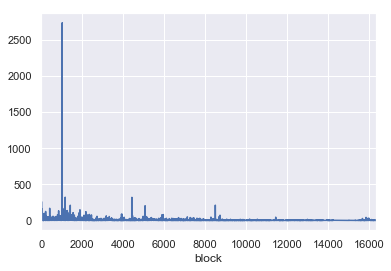

In [182]:
raw_data.groupby('block').size().plot()

# it reads as numerical, but infact categorical
# can be deleted

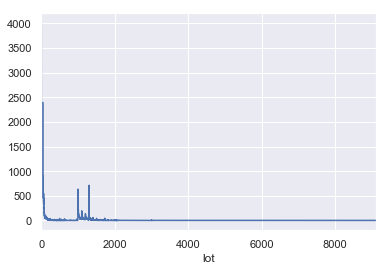

In [27]:
raw_data.groupby('lot').size().plot()

# it reads as numerical, but infact categorical
# can be deleted

In [27]:
raw_data.groupby('easement').size()

# can be deleted

easement
     85973
E        2
dtype: int64

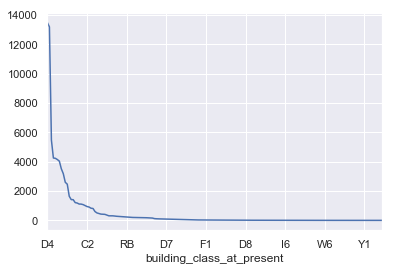

In [28]:
raw_data.groupby('building_class_at_present').size().sort_values(ascending=False).plot()

# raw_data[raw_data.building_class_at_present == 'C2'].groupby('building_class_at_present').size()

# some has +100 items? need domain knowledge to extract a meaningful sense
# building_class_at_present: may be mapped into 3 groups to use later ?
# no white-spaces at the end

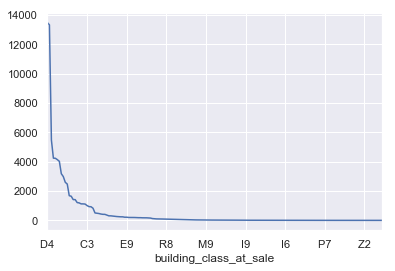

In [29]:
raw_data.groupby('building_class_at_sale').size().sort_values(ascending=False).plot()

In [30]:
raw_data.groupby('apartment_number').size().sort_values(ascending=False).head(10)

# len(raw_data.groupby('apartment_number').size()) 

# raw_data[raw_data.apartment_number == 'TIMES']

# 63830 is empty %74 empty
# 4000+ diff. apartment_number in 85K rows.
# apartment_number has white-spaces at the end

apartment_number
                63830
TIMES             599
4                 273
3B                249
3A                244
2                 235
3                 233
6                 228
2A                222
4A                219
dtype: int64

In [31]:
raw_data.groupby('zipcode').size().sort_values(ascending=False).head(10)#.plot(kind='pie')

# 10019 zipcode is %7 of houses
# 70K houses in 100 zipcodes

# no double rows

zipcode
10019    6193
10023    1514
11207    1357
11201    1314
10011    1261
11375    1200
10314    1164
10016    1147
10022    1119
11215    1106
dtype: int64

In [32]:
raw_data[['residential_units', 'commercial_units', 'total_units']].head(20)

# total = residental + commercial ?
# if there are dif, can we set to commercial or we should delete  or we may use to create a dummy category ?
# if total = 0 , what we should do?

,residential_units,commercial_units,total_units
0,0,NaN,0
1,0,NaN,0
2,0,NaN,0
3,0,NaN,0
4,0,NaN,0
5,0,NaN,0
6,0,NaN,0
7,0,NaN,0
8,0,NaN,0
9,0,NaN,0


## Export OUTPUT file

In [194]:
data_prepared = raw_data

data_prepared = data_prepared[data_prepared.sale_price != 0] #28K records
data_prepared = data_prepared[data_prepared.building_class_name.notna()] #1500 rows
data_prepared = data_prepared[data_prepared.tax_class_at_present != '  '] #271 rows

len(data_prepared)

# deleted ~30K rows

55568

In [195]:
data_prepared.drop(['borough', 'building_class_category', 'building_class',
                    'block', 'lot',
                    'easement', 
                    'address', 'apartment_number', 
                    'tax_class_at_sale', 'building_class_at_sale'], \
                  axis=1, \
                  inplace=True)

In [196]:
data_prepared.dtypes

borough_name                         object
neighborhood                         object
building_class_name                  object
tax_class_at_present                 object
building_class_at_present            object
address_                             object
zipcode                               int64
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                      int64
gross_square_feet                     int64
year_built                            int64
sale_date                    datetime64[ns]
sale_price                          float64
dtype: object

## outliers esp. for numerical features 

- **data_cleaned** is the outcome data frame

In [188]:
len(data_prepared)

55568

(29311, 24880, 24119, <matplotlib.axes._subplots.AxesSubplot at 0x1a31fbda58>)

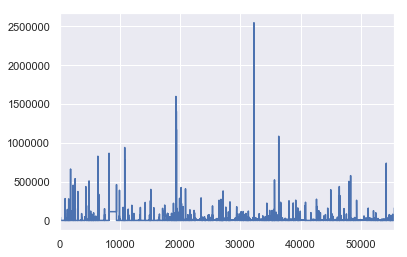

In [201]:
# below type plotting, x axis contains dump values !!!!

outliers = data

x = outliers[outliers.gross_square_feet == 0]
y = outliers[(outliers.gross_square_feet > 0) & (outliers.gross_square_feet <= 100000)]

z = outliers[(outliers.gross_square_feet > 0) & (outliers.gross_square_feet <= 20000)]

len(x), len(y), len(z), outliers.gross_square_feet.plot()

# gross_square_feet>500K seems outliers! or >20K (seems much better)

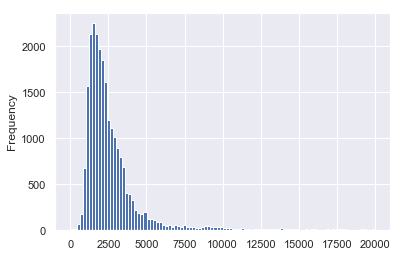

In [202]:
z.gross_square_feet.plot.hist(bins=100)

(0,
 55544,
 55353,
 51593,
 50462,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4d709f98>)

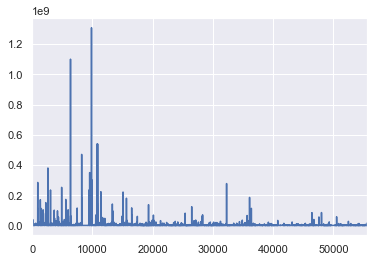

In [235]:
x = outliers[outliers.sale_price == 0]

y = outliers[outliers.sale_price <= 200000000]

z = outliers[outliers.sale_price <= 25000000]
k = outliers[outliers.sale_price <= 2500000]  # still covers most of the rows :)

m = outliers[outliers.sale_price <= 2000000]  # still covers most of the rows :)

len(x), len(y), len(z), len(k), len(m), outliers.sale_price.plot()

# data contains >0 sale_price, but it seems we also elimine under some values?

# over sale_price>2M usd seems outliers !
# or we may also create a category column depending sales_price (< 1M, ..., >200M and <500M, >500M, >900M ...)

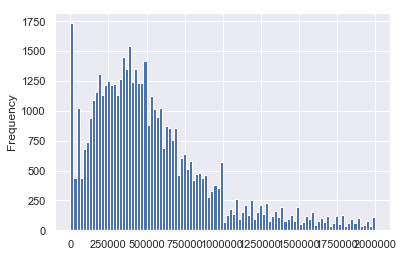

In [242]:
m.sale_price.plot.hist(bins=100)

In [245]:
data_cleaned = data_prepared

data_cleaned = data_cleaned[(data_cleaned.gross_square_feet > 0) & (data_cleaned.gross_square_feet <= 20000)]

data_cleaned = data_cleaned[(data_cleaned.sale_price < 2000000)]

len(data_cleaned)

22627

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a504cd240>,
      dtype=object)

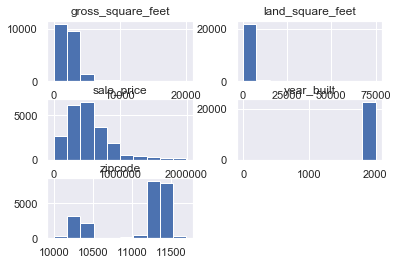

In [251]:
data_cleaned.hist()

## Enrichment etc..

- read OUTPUT data as **data_prepared** generated above

#### Problem w/ features
we have 
- so many **categorical features** which _must be mapped_ into less values, to predict sale_price and, 
- **less numerical features**, which will be used to predict sale_price

In [346]:
data_cleaned.dtypes

borough_name                         object
neighborhood                         object
building_class_name                  object
tax_class_at_present                 object
building_class_at_present            object
address_                             object
zipcode                               int64
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                      int64
gross_square_feet                     int64
year_built                            int64
sale_date                    datetime64[ns]
sale_price                          float64
dtype: object

In [34]:
data = pd.read_csv('dataset/housing/output_after_eda.csv', \
                       dtype={'borough_name': object, 'neighborhood': object, 'building_class_name': object,
                              'tax_class_at_present': object, 'building_class_at_present': object,
                              'address_': object, 'zipcode': object, 'residential_units': object,
                              'commercial_units': object, 'total_units': object, 'land_square_feet': np.int64, 
                              'gross_square_feet': np.int64, 'year_built': object,
                              'sale_price': np.int64}, \
                       parse_dates=['sale_date'], \
                       infer_datetime_format=True)



data.head(3)

,borough_name,neighborhood,building_class_name,tax_class_at_present,building_class_at_present,address_,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
0,Manhattan,ALPHABET CITY,THREE FAMILY HOMES,1,C0,243 EAST 7TH STREET,10009,3,NaN,3,2381,3084,1899,2013-03-06,3150000
1,Manhattan,ALPHABET CITY,TAX CLASS 1 CONDOS,1C,R6,238 EAST 4TH STREET,10009,1,NaN,1,0,0,1955,2013-03-27,3450000
2,Manhattan,ALPHABET CITY,RENTALS - WALKUP APARTMENTS,2,C4,715 EAST 5TH STREET,10009,20,NaN,20,2426,9345,1900,2012-09-06,3650000


In [35]:
data.dtypes

borough_name                         object
neighborhood                         object
building_class_name                  object
tax_class_at_present                 object
building_class_at_present            object
address_                             object
zipcode                              object
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                      int64
gross_square_feet                     int64
year_built                           object
sale_date                    datetime64[ns]
sale_price                            int64
dtype: object

In [36]:
data.describe(include='all')

,borough_name,neighborhood,building_class_name,tax_class_at_present,building_class_at_present,address_,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
count,55568,55567,55568,55568,55568,55568,55568,37377,15502,37377,5.556800e+04,5.556800e+04,55568,55568,5.556800e+04
unique,5,253,38,10,147,45210,185,146,21,155,NaN,NaN,152,364,NaN
top,Manhattan,MIDTOWN WEST,COOPS - ELEVATOR APARTMENTS,2,D4,102 WEST 57TH STREET,10019,0,0,1,NaN,NaN,0,2012-12-20 00:00:00,NaN
freq,18295,2386,12525,26469,12257,917,2373,16659,14733,14958,NaN,NaN,4700,537,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.730345e+03,5.149269e+03,NaN,NaN,1.318202e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.989225e+04,2.834796e+04,NaN,NaN,1.111268e+07
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,2.750000e+05


In [132]:
x = data.groupby('residential_units').size().sum()

y = data.groupby('commercial_units').size().sum()

q = data[(data.residential_units.isna()) & (data.commercial_units.isna())]

m = data.groupby('total_units').size().sum()

x, y, len(q), (55000-m)

# (32%) 18K of 55K records empty regarding total_units
# we need many categorical features which must be mapped into less values, to predict sale_price
# and, less numerical features, which can be used to predict sale_price

(37377, 15502, 18191, 17623)

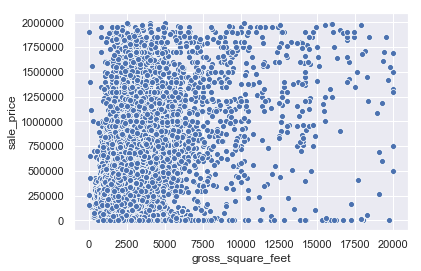

In [261]:
ax1 = sns.scatterplot(x='gross_square_feet', y='sale_price', palette='Set2', data=data_cleaned)


In [66]:
zzz = data

zzz.groupby('building_class_name').size()#.plot(kind='pie')

# we should create a column such as family houses

building_class_name
ASYLUMS AND HOMES                              8
COMMERCIAL CONDOS                            662
COMMERCIAL GARAGES                           383
COMMERCIAL VACANT LAND                       200
CONDO-RENTALS                                 17
CONDOPS                                     1320
CONDOS - 2-10 UNIT RESIDENTIAL               901
CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT       50
CONDOS - ELEVATOR APARTMENTS                9232
CONDOS - WALKUP APARTMENTS                   722
COOPS - ELEVATOR APARTMENTS                12525
COOPS - WALKUP APARTMENTS                   2372
EDUCATIONAL FACILITIES                        33
FACTORIES                                    166
HOSPITAL AND HEALTH FACILITIES                17
INDOOR PUBLIC AND CULTURAL FACILITIES         12
LOFT BUILDINGS                                78
LUXURY HOTELS                               1225
OFFICE BUILDINGS                             268
ONE FAMILY HOMES                            9691


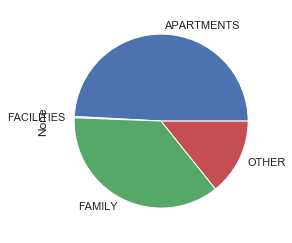

In [41]:
data_enriched = data

data_enriched.loc[data_enriched.building_class_name.str.contains('FAMILY'), 'building_class_map'] = 'FAMILY'
data_enriched.loc[data_enriched.building_class_name.str.contains('APARTMENT'), 'building_class_map'] = 'APARTMENTS'
data_enriched.loc[data_enriched.building_class_name.str.contains('FACILITIES'), 'building_class_map'] = 'FACILITIES'

# this keeps getting decreased, above lines increased
data_enriched.loc[data_enriched.building_class_map.isna(), 'building_class_map'] = 'OTHER'

data_enriched.groupby('building_class_map').size().plot(kind='pie')

# len(data_enriched[data_enriched.building_class_map.notna()])
# 20K records contains family 

In [63]:
# data.gross_square_feet.plot()
kz = data[data.gross_square_feet == 0]


len(kz)

# 29K of filled sales_price rows have 0 square_feet

29311

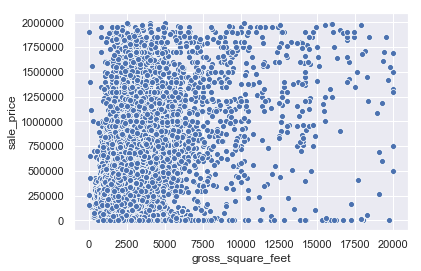

In [263]:
ax10 = sns.scatterplot(x='gross_square_feet', y='sale_price', palette='Set2', data=data_cleaned)


### Cross Analysis

In [39]:
# k = data[['building_class_name', 'residential_units']] 


# k.groupby([ 'building_class_name', 'residential_units']).size()#.sort_values(ascending=False).unstack('residential_units')#.plot(kind='pie')

In [206]:
export_csv = data_cleaned.to_csv (r'./dataset/housing/output_after_eda.csv', 
                                  index = None,
                                  header = True) 

export_csv